# Imports

In [216]:
import pandas as pd
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import airportsdata
import warnings
warnings.filterwarnings('ignore')

In [217]:
try:
  df_train = pd.read_csv('challenge_set.csv')
  df_test = pd.read_csv('submission_set.csv')
  print("Size of train set:", len(df_train), 'samples')
  print("Size of test set:", len(df_test), 'samples')
except:
  !gdown https://drive.google.com/uc?id=1k50qffaKdLo4Oy_6tBMJtZlrE4iwh6P7 -O challenge_set.csv
  !gdown https://drive.google.com/uc?id=1W_7YPIjxRr5m3KW4tmOM6548RYzy53vC -O submission_set.csv
  df_train = pd.read_csv('challenge_set.csv')
  df_test = pd.read_csv('submission_set.csv')
  print("Size of train set:", len(df_train), 'samples')
  print("Size of test set:", len(df_test), 'samples')

Size of train set: 369013 samples
Size of test set: 105959 samples


In [218]:
df_train.head(1)

,flight_id,date,callsign,adep,name_adep,country_code_adep,ades,name_ades,country_code_ades,actual_offblock_time,arrival_time,aircraft_type,wtc,airline,flight_duration,taxiout_time,flown_distance,tow
0,248763780,2022-01-01,3840d84f25d3f5fcc0a1be3076bb4039,EGLL,London Heathrow,GB,EICK,Cork,IE,2022-01-01T13:46:00Z,2022-01-01T15:04:56Z,A320,M,a73f82288988b79be490c6322f4c32ed,61,18,321,54748.0


# EDA

## Geographic Data

In [219]:
import airportsdata
# Load the airports data as a dictionary
airports_dict = airportsdata.load()
airports = pd.DataFrame.from_dict(airports_dict, orient='index')

In [220]:
airports_counts = df_train.groupby('adep').size().reset_index(name='total_flights')
airports_count_dict = airports_counts.set_index('adep')['total_flights'].to_dict()
world_map = folium.Map(location=[20, 0], zoom_start=2)

# Add airport markers
for index, row in airports.iterrows():
    # Ensure lat/lon values are valid
    airport = row['icao']
    if airport in airports_count_dict.keys():
      n = airports_count_dict[airport]
      if n<100:
        color = 'lightgreen'
      elif n<500:
        color = 'yellow'
      elif n<1000:
        color = 'orange'
      else:
        color = 'red'
      if pd.notnull(row['lat']) and pd.notnull(row['lon']):
          folium.CircleMarker(
              location=[row['lat'], row['lon']],
              radius=2*np.log(n+1),
              color=color,
              fill=True,
              fill_opacity=0.6,
              tooltip=f"Flights from {airports.loc[airport]['city']}: {n}",
          ).add_to(world_map)

# Save the map to an HTML file
world_map.save("airports_map.html")

# Display the map
world_map


## Aircraft Type


In [221]:
aircraft_types = df_train['aircraft_type'].value_counts().index
top_aircraft_types = aircraft_types[0:10]

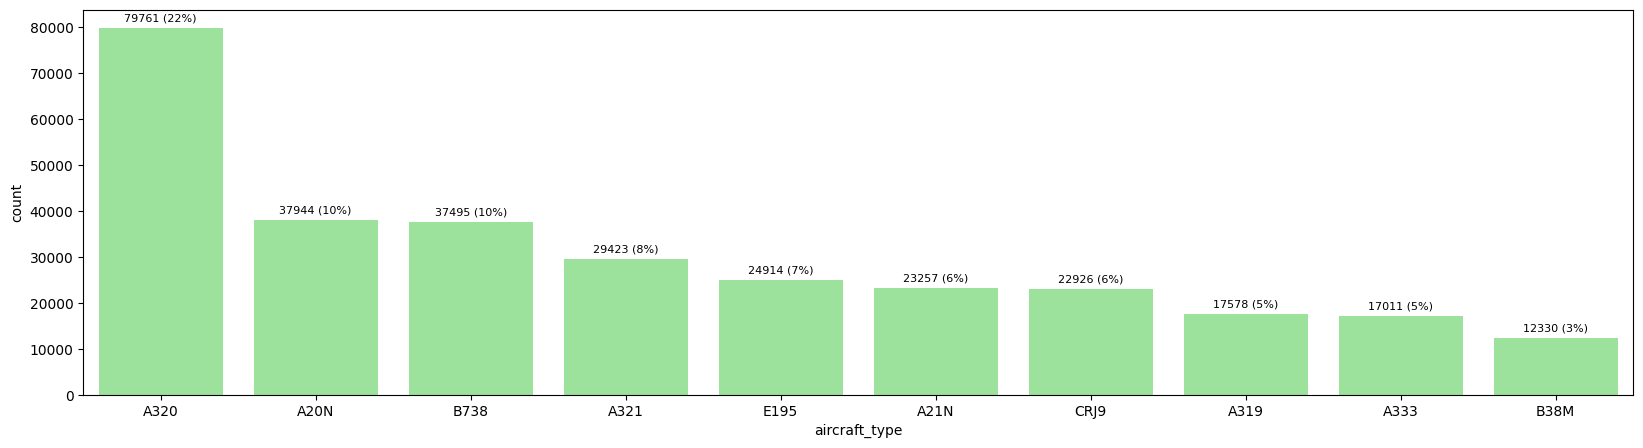

In [222]:
plt.figure(figsize=(20, 5))

# Create the dataframe of top countries with total flights
at_counts = df_train.groupby('aircraft_type').size().reset_index(name='total_flights')

# Create the countplot
ax = sns.countplot(data=df_train[df_train['aircraft_type'].isin(top_aircraft_types)],
                   x='aircraft_type',
                   color = 'lightgreen',
                   order = df_train[df_train['aircraft_type'].isin(top_aircraft_types)]['aircraft_type'].value_counts().index)

# Add the value on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}'+' ('+ f'{100*p.get_height()/len(df_train):.0f}'+'%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline',
                fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Show the plot
plt.show()

## Focus on Countries (103 unique)

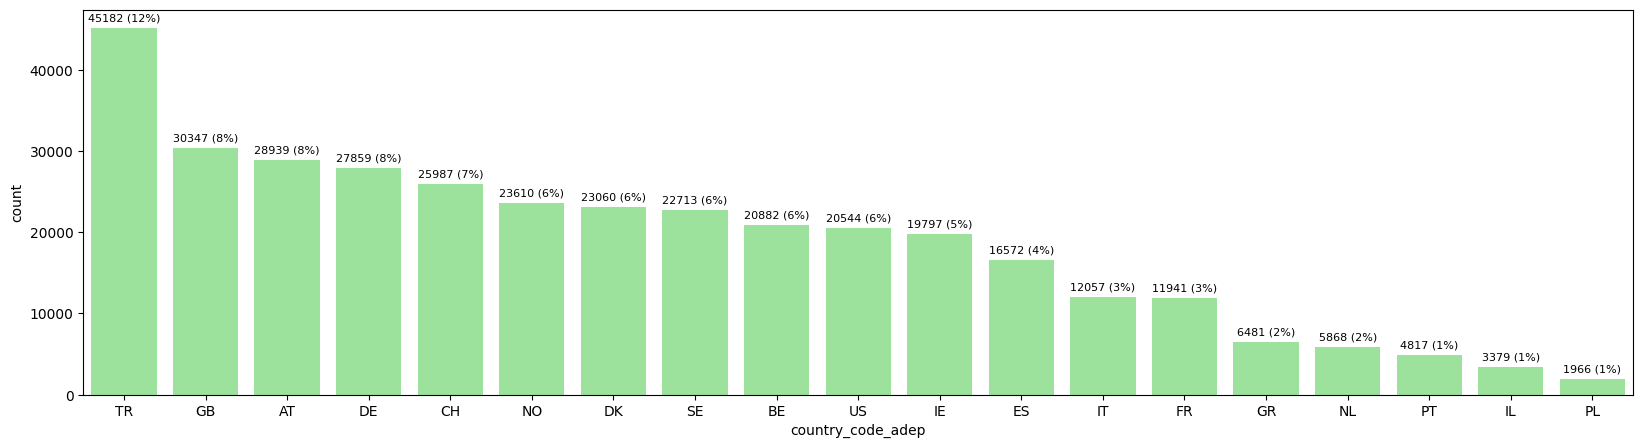

In [223]:
threshold = len(df_train)/200 # keeping only the instance that count for more than 0.5% of the dataset
plt.figure(figsize=(20, 5))

# Create the dataframe of top countries with total flights
country_counts = df_train.groupby('country_code_adep').size().reset_index(name='total_flights')
top_countries = country_counts[country_counts['total_flights'] >= threshold]['country_code_adep']

# Create the countplot
ax = sns.countplot(data=df_train[df_train['country_code_adep'].isin(top_countries)], x='country_code_adep',
                   color = "lightgreen",
                   order = df_train[df_train['country_code_adep'].isin(top_countries)]['country_code_adep'].value_counts().index )

# Add the value on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}'+' ('+ f'{100*p.get_height()/len(df_train):.0f}'+'%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline',
                fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()



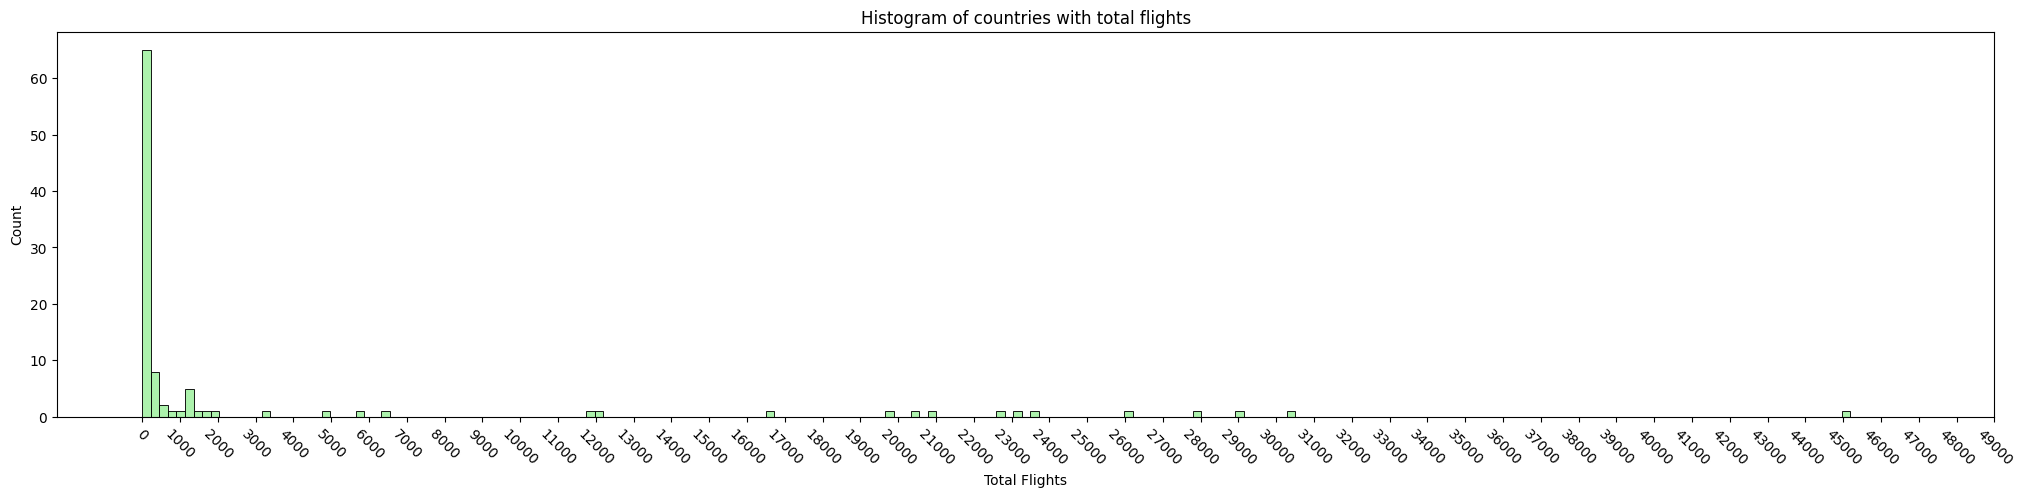

In [224]:
# Plot the filtered data
plt.figure(figsize=(25, 5))
ax = sns.histplot(data=country_counts, x='total_flights', bins = 200,
                  color = 'lightgreen')
ax.set_xticks(np.arange(0,50000,1000))
plt.xticks(rotation = -45)
plt.title(f'Histogram of countries with total flights')
plt.xlabel('Total Flights')
plt.show()

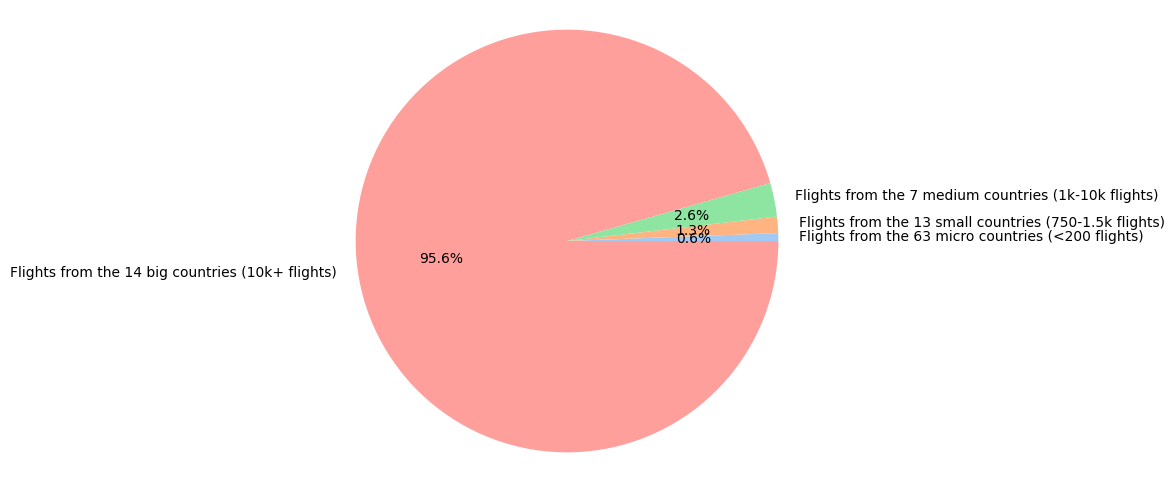

In [225]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (list)
flights_from_T1_countries = country_counts[country_counts['total_flights'] < 200]['total_flights']
flights_from_T2_countries = country_counts[country_counts['total_flights'] < 750][country_counts['total_flights'] > 200]['total_flights']
flights_from_T3_countries = country_counts[country_counts['total_flights'] < 1500][country_counts['total_flights'] > 750]['total_flights']
flights_from_T4_countries = country_counts[country_counts['total_flights'] > 10000]['total_flights']
data = [flights_from_T1_countries.sum(), flights_from_T2_countries.sum(), flights_from_T3_countries.sum(),flights_from_T4_countries.sum()]

# Labels for each slice
labels = [f'Flights from the {len(flights_from_T1_countries)} micro countries (<200 flights)',
          f'Flights from the {len(flights_from_T2_countries)} small countries (750-1.5k flights)',
          f'Flights from the {len(flights_from_T3_countries)} medium countries (1k-10k flights)',
          f'Flights from the {len(flights_from_T4_countries)} big countries (10k+ flights)']

# Optional: Custom color palette from Seaborn
colors = sns.color_palette('pastel')

# Create the pie chart
plt.figure(figsize=(6,6))
plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.show()


<Figure size 2000x500 with 0 Axes>

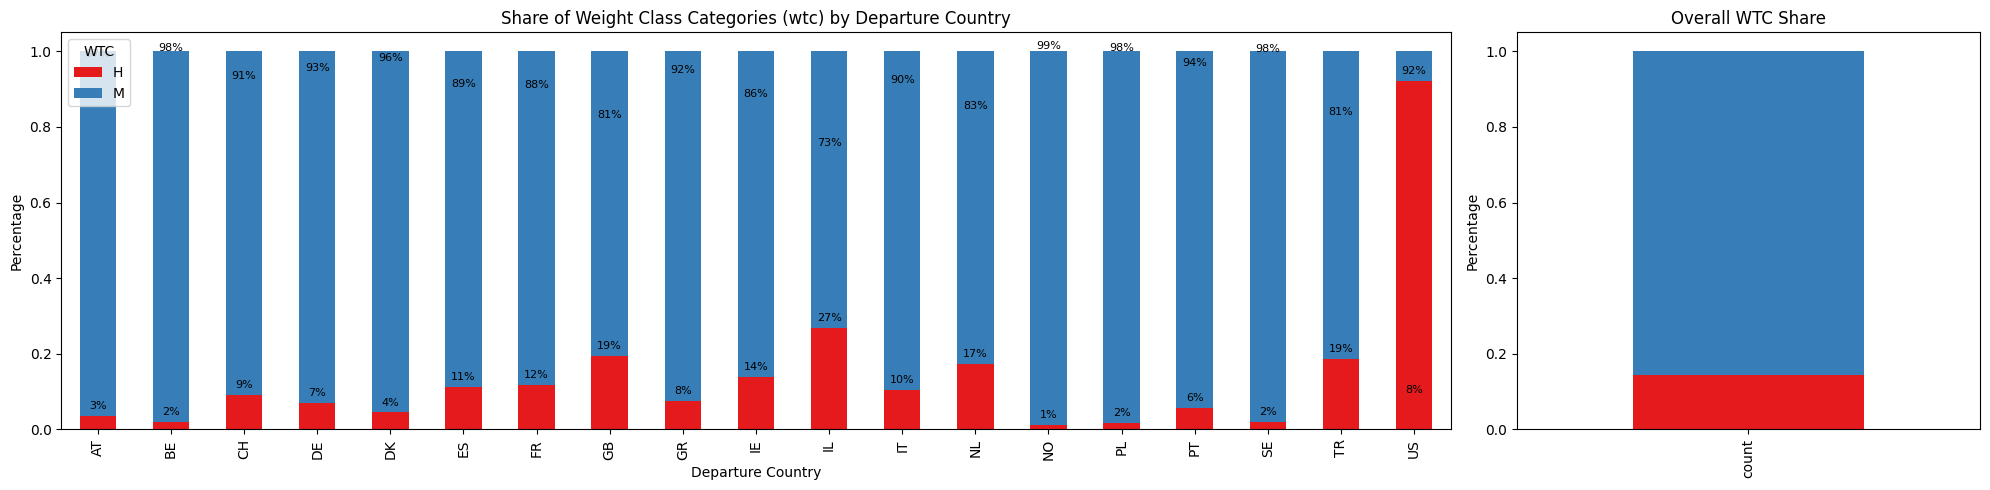

In [226]:
# Group by the departure country and wtc, then count occurrences
df_grouped = df_train[df_train['country_code_adep'].isin(top_countries)].groupby(['country_code_adep', 'wtc']).size().reset_index(name='count')
df_grouped['percentage'] = df_grouped.groupby('country_code_adep')['count'].transform(lambda x: x / x.sum())
df_pivot = df_grouped.pivot(index='country_code_adep', columns='wtc', values='percentage').fillna(0)

overall_wtc_share = df_grouped.groupby('wtc')['count'].sum() / df_grouped['count'].sum()
overall_wtc_df = pd.DataFrame(overall_wtc_share).T  # Transpose to make it a single row DataFrame
plt.figure(figsize = (20,5))
# Create a figure with two subplots: one for the main plot, one for the overall share
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20,5))

# Main stacked bar plot for the countries
df_pivot.plot(kind='bar', stacked=True, ax=ax1, color=sns.color_palette("Set1", len(df_pivot.columns)))

# Add labels and title for the main plot
ax1.set_title('Share of Weight Class Categories (wtc) by Departure Country')
ax1.set_ylabel('Percentage')
ax1.set_xlabel('Departure Country')
ax1.legend(title='WTC')

# Stacked bar plot for the overall wtc share
overall_wtc_df.plot(kind='bar', stacked=True, ax=ax2, color=sns.color_palette("Set1", len(overall_wtc_df.columns)))

# Add labels and title for the overall plot
ax2.set_title('Overall WTC Share')
ax2.set_ylabel('Percentage')
ax2.set_xlabel('')
ax2.get_legend().remove()  # Remove the legend here since it's shared with the main plot

for p in ax1.patches:
    ax1.annotate(f'{100*p.get_height():.0f}'+'%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline',
                fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

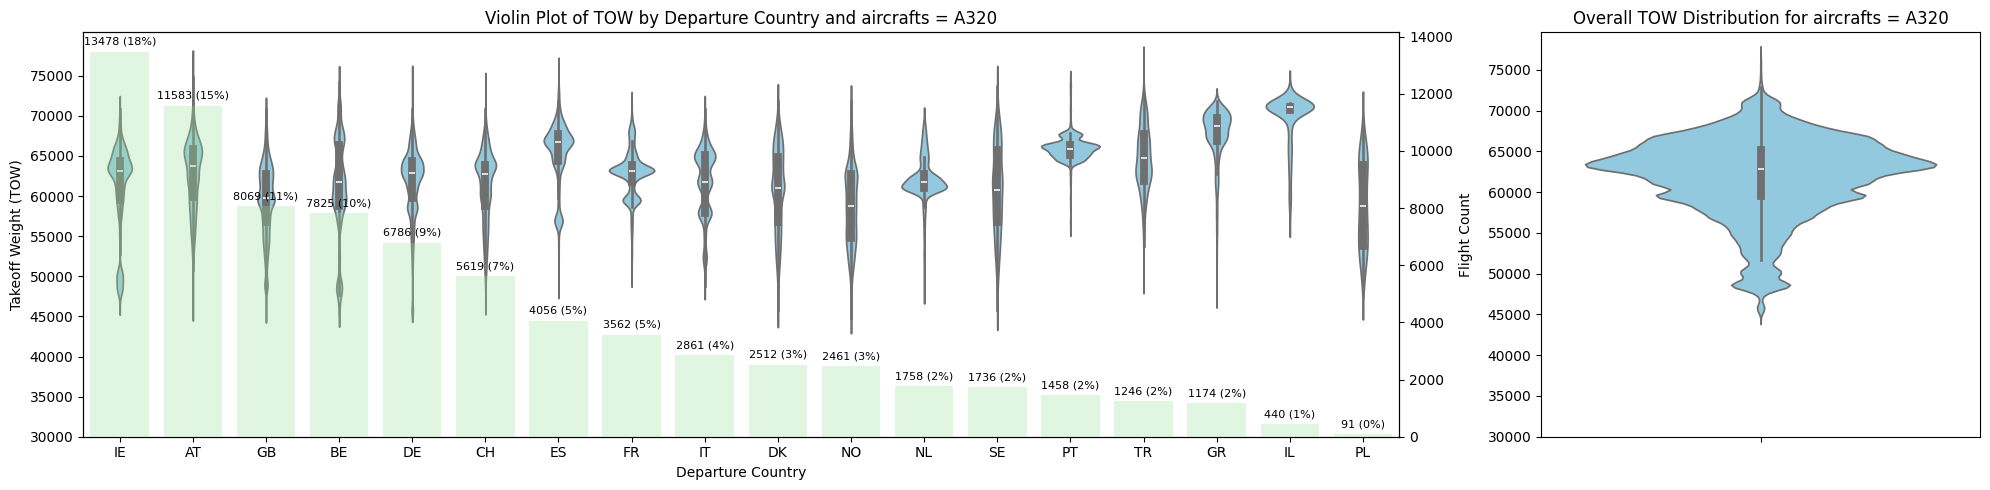

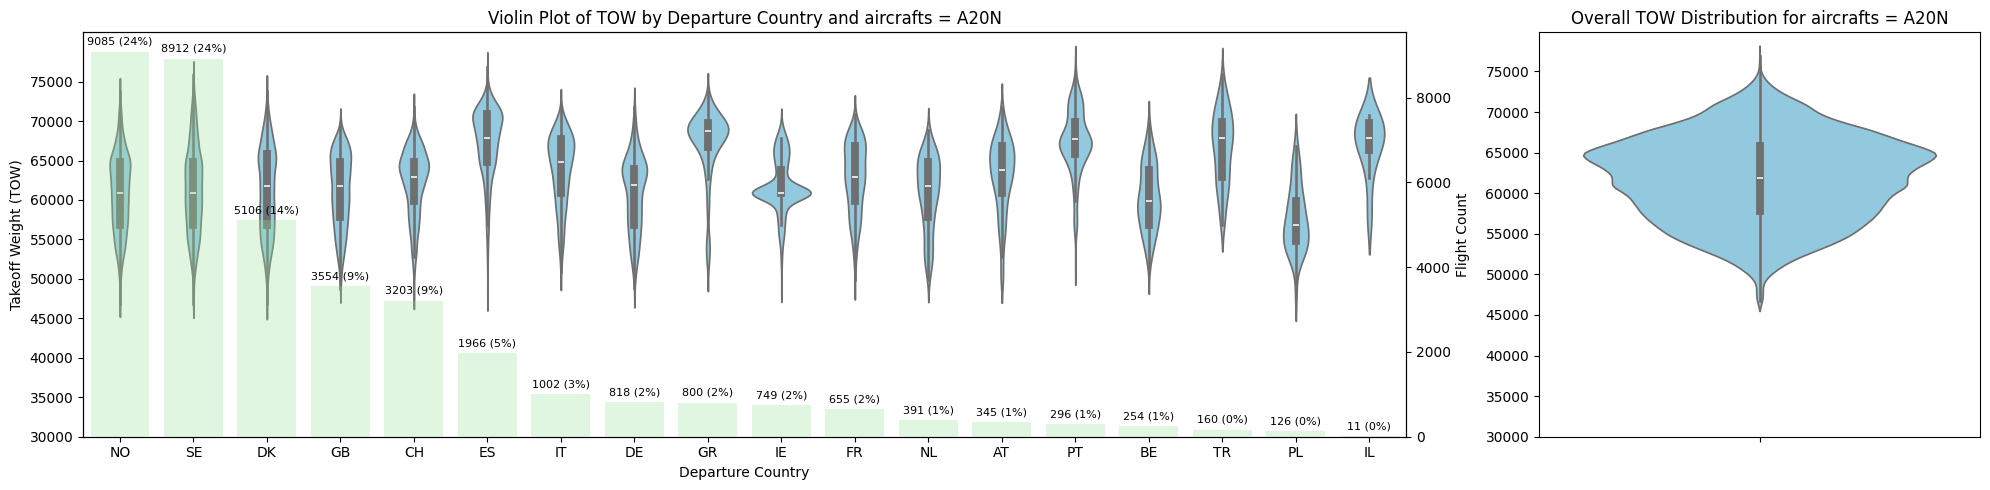

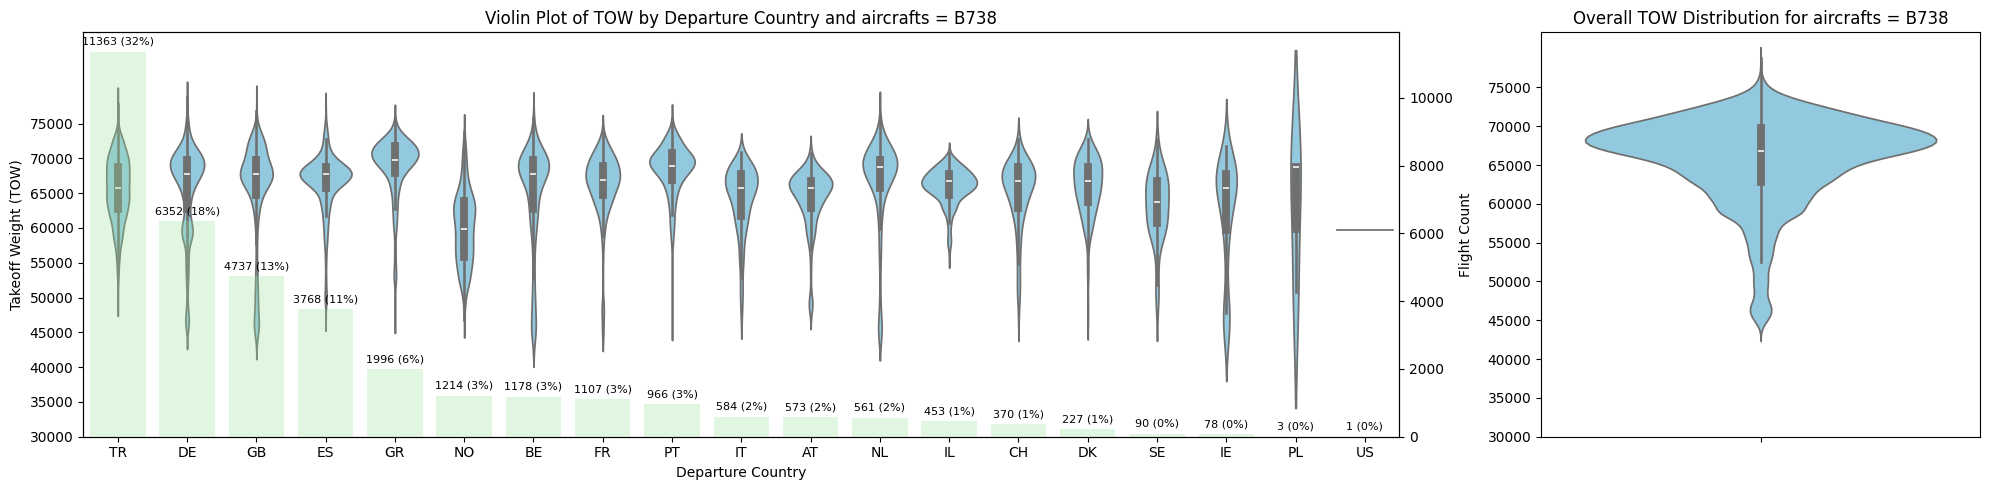

In [227]:
# Filter the dataset to keep only the rows for the top countries
df_filtered = df_train[df_train['country_code_adep'].isin(top_countries)]
p = 3

for aircraft_type in top_aircraft_types[0:p]:
    # Filter for the specific aircraft type
    df_at = df_filtered[df_filtered['aircraft_type'] == aircraft_type]

    # Aggregate flight counts by country and sort them in descending order
    country_counts_at = df_at['country_code_adep'].value_counts().index

    # Create two subplots: one for the country-specific plot, one for the overall plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [3, 1]})

    # Violin plot for the TOW by country, sorted by flight counts
    sns.violinplot(data=df_at, x='country_code_adep', y='tow', ax=ax1, color="skyblue", order=country_counts_at)
    ax1.set_title('Violin Plot of TOW by Departure Country and aircrafts = ' + aircraft_type)
    ax1.set_xlabel('Departure Country')
    ax1.set_ylabel('Takeoff Weight (TOW)')
    ax1.set_yticks(np.arange(30000,80000,5000))
    # Create a secondary axis sharing the same x-axis for the count plot, sorted by flight counts
    ax1b = ax1.twinx()  # Secondary y-axis
    sns.countplot(data=df_at, x='country_code_adep', ax=ax1b, color="lightgreen", alpha=0.3, order=country_counts_at)
    ax1b.set_ylabel('Flight Count')  # Set label for the count plot
    ax1b.grid(False)  # Disable grid on the secondary axis

    for p in ax1b.patches:
      ax1b.annotate(f'{p.get_height():.0f}'+' ('+ f'{100*p.get_height()/len(df_at):.0f}'+'%)',
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='baseline',
                  fontsize=8, color='black', xytext=(0, 5),
                  textcoords='offset points')

    # Violin plot for the overall TOW distribution
    sns.violinplot(data=df_at, y='tow', ax=ax2, color="skyblue")
    ax2.set_title('Overall TOW Distribution for aircrafts = ' + aircraft_type)
    ax2.set_xlabel('')  # No x-axis label needed
    ax2.set_ylabel('')  # No y-axis label for the overall plot
    ax2.set_yticks(np.arange(30000,80000,5000))
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


## Focus on airports (460 unique)

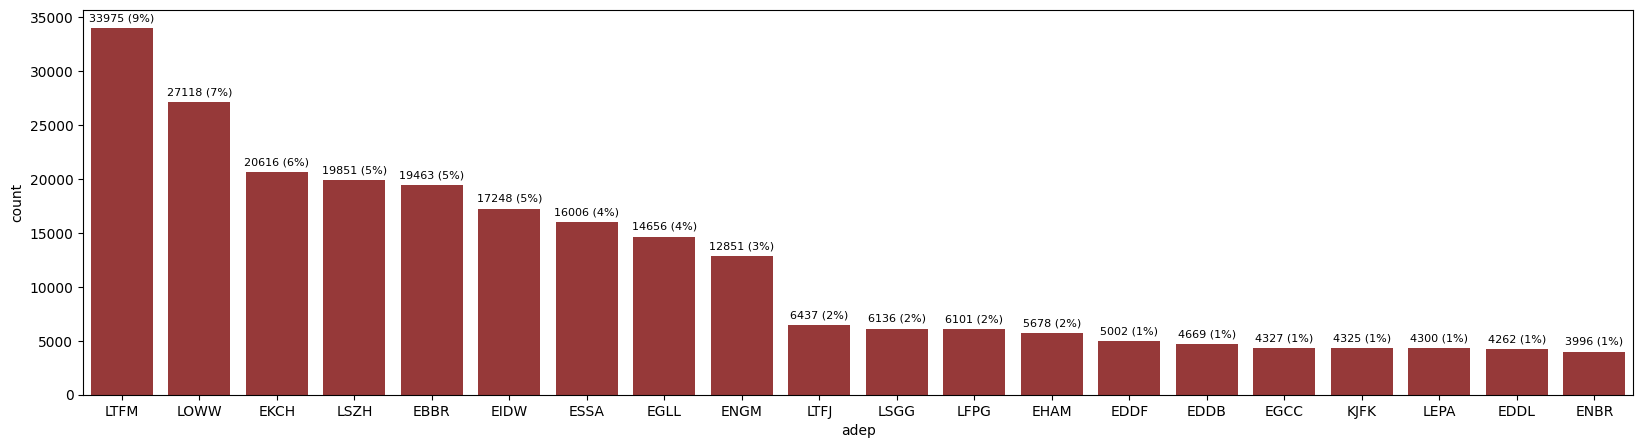

In [228]:
plt.figure(figsize = (20,5))

airports_counts = df_train.groupby('adep').size().reset_index(name='total_flights')
top_airports = airports_counts[airports_counts['total_flights'] >= 2*threshold]['adep']
ax = sns.countplot(df_train[df_train['adep'].isin(top_airports)], x = 'adep',
                   color = 'brown',
                   order = df_train[df_train['adep'].isin(top_airports)]['adep'].value_counts().index)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}'+' ('+ f'{100*p.get_height()/len(df_train):.0f}'+'%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline',
                fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

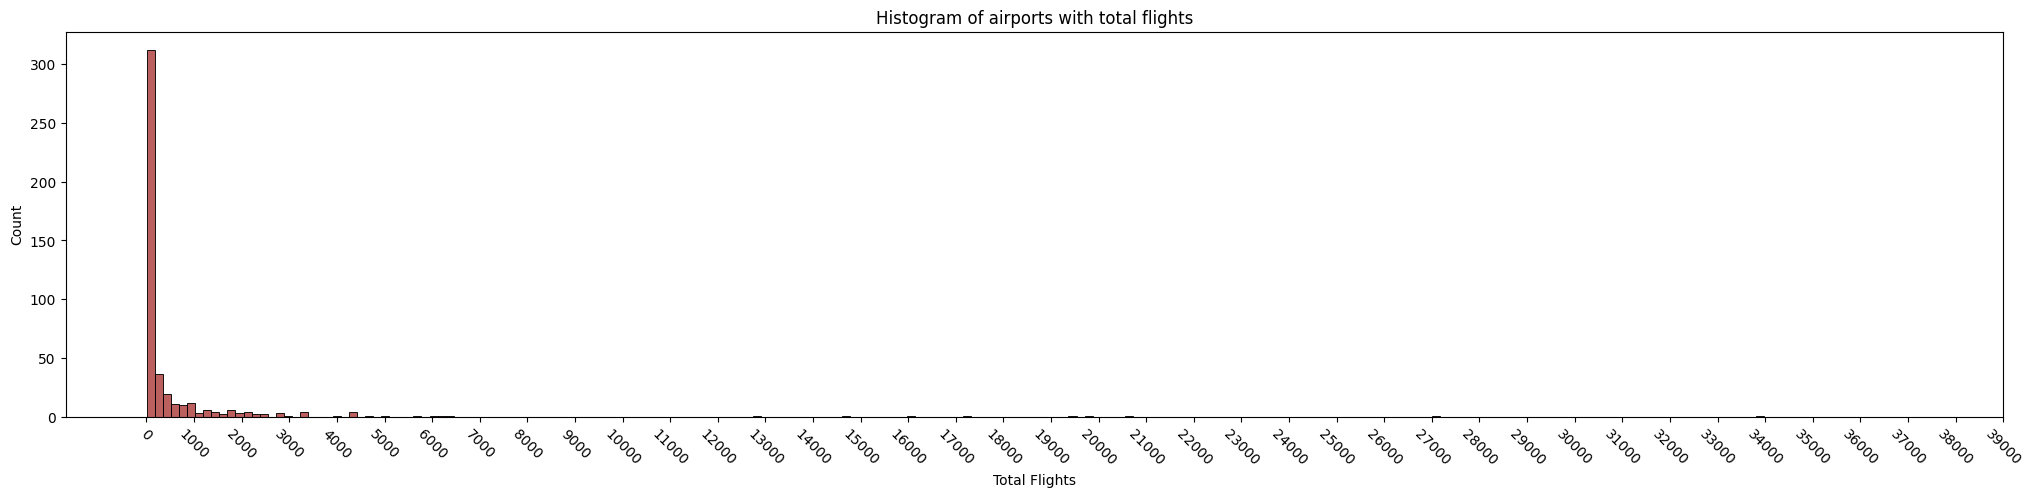

In [229]:
# Plot the filtered data
plt.figure(figsize=(25, 5))
ax = sns.histplot(data=airports_counts, x='total_flights', bins = 200,
                  color = 'brown')
ax.set_xticks(np.arange(0,40000,1000))
plt.xticks(rotation = -45)
plt.title(f'Histogram of airports with total flights')
plt.xlabel('Total Flights')
plt.show()



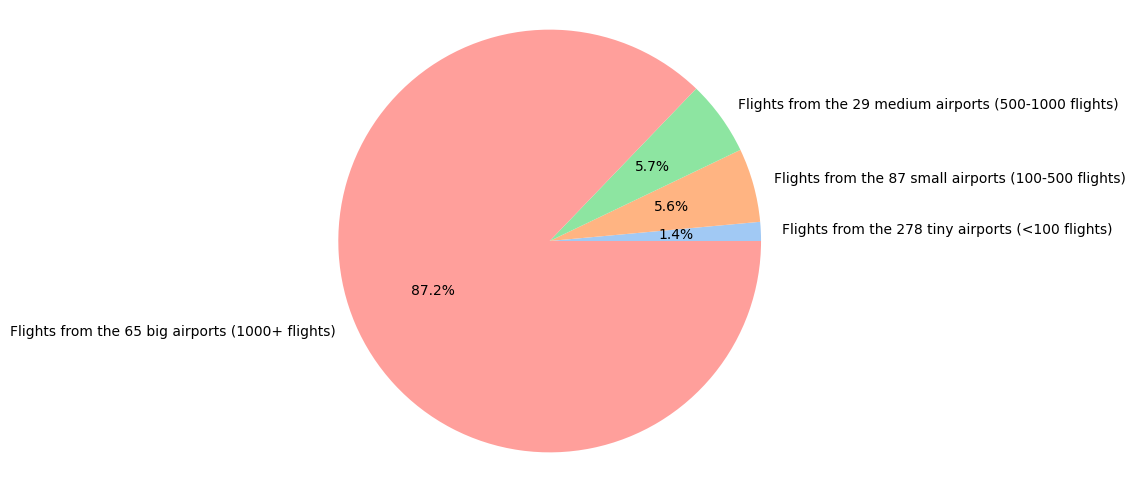

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example data (list)
flights_from_T1_airports = airports_counts[airports_counts['total_flights'] < 100]['total_flights']
flights_from_T2_airports = airports_counts[airports_counts['total_flights'] < 500][airports_counts['total_flights'] > 100]['total_flights']
flights_from_T3_airports = airports_counts[airports_counts['total_flights'] < 1000][airports_counts['total_flights'] > 500]['total_flights']
flights_from_T4_airports = airports_counts[airports_counts['total_flights'] > 1000]['total_flights']
data = [flights_from_T1_airports.sum(), flights_from_T2_airports.sum(), flights_from_T3_airports.sum(),flights_from_T4_airports.sum()]

# Labels for each slice
labels = [f'Flights from the {len(flights_from_T1_airports)} tiny airports (<100 flights)',
          f'Flights from the {len(flights_from_T2_airports)} small airports (100-500 flights)',
          f'Flights from the {len(flights_from_T3_airports)} medium airports (500-1000 flights)',
          f'Flights from the {len(flights_from_T4_airports)} big airports (1000+ flights)']

# Optional: Custom color palette from Seaborn
colors = sns.color_palette('pastel')

# Create the pie chart
plt.figure(figsize=(6,6))
plt.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=0)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()


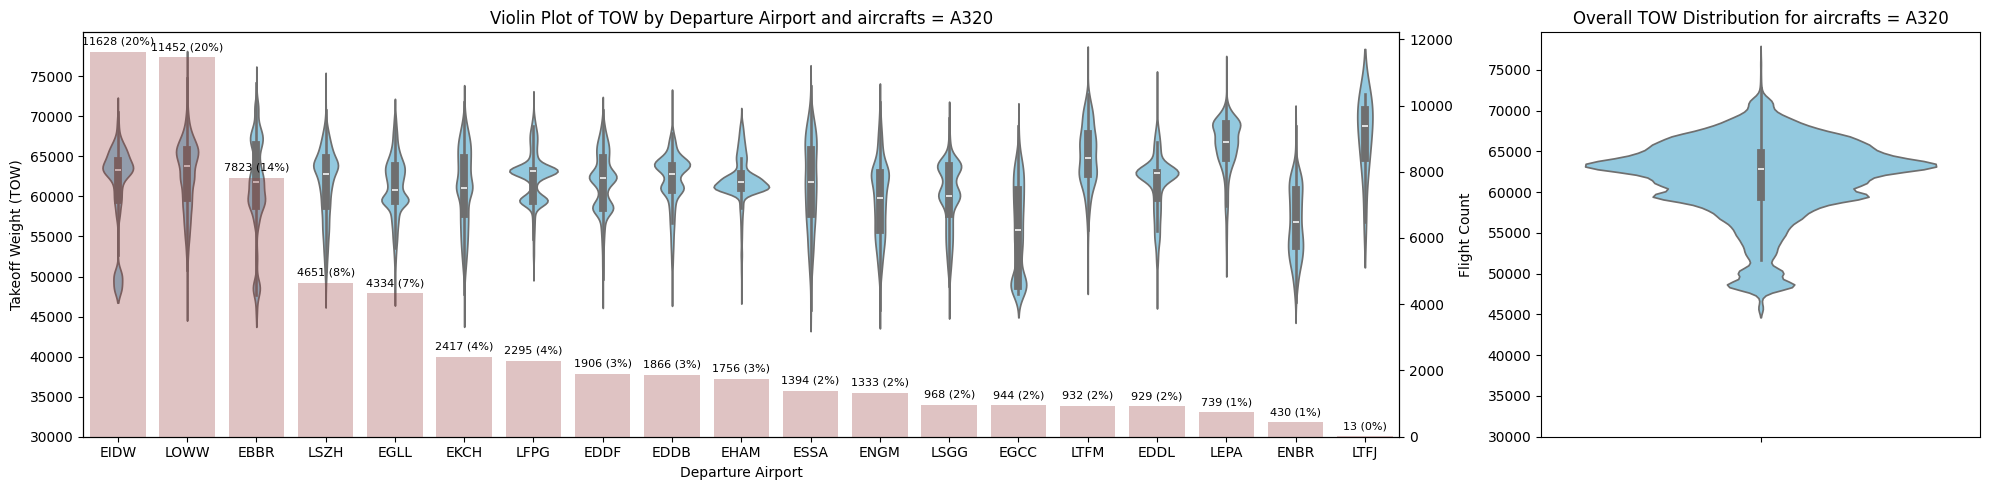

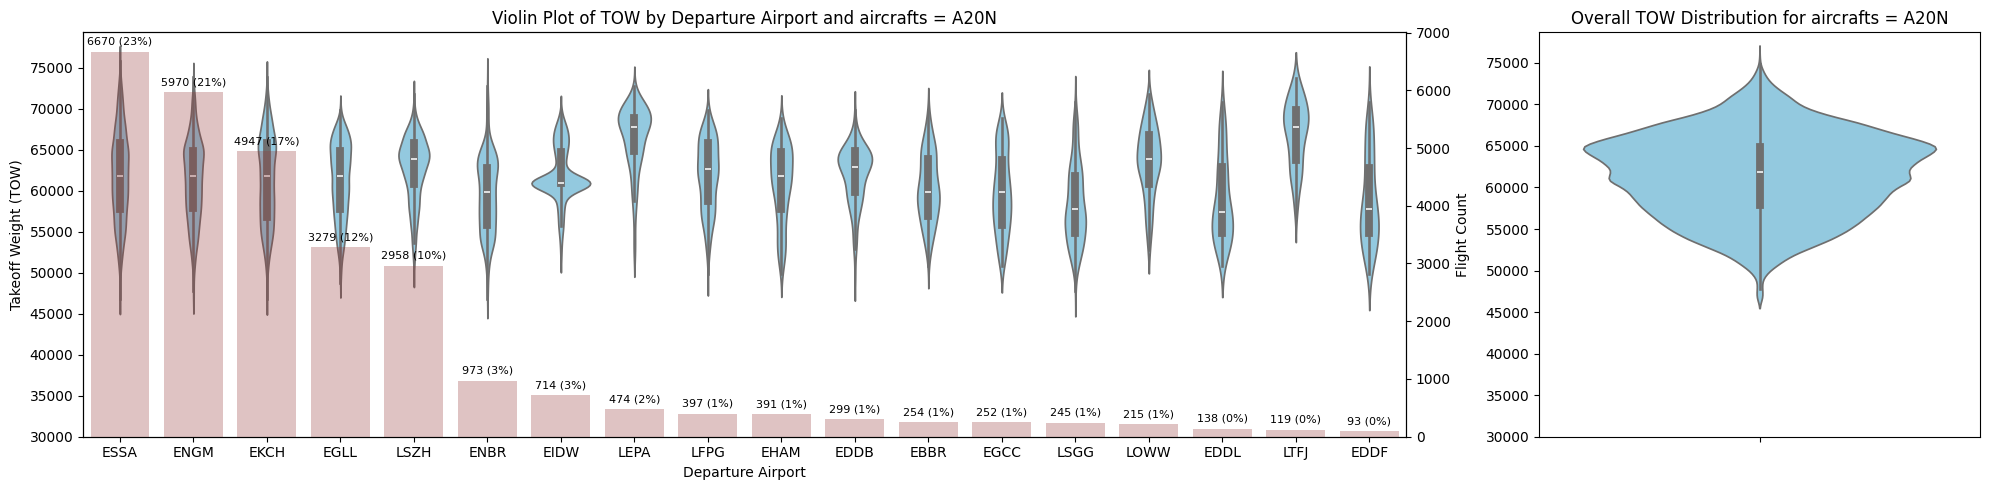

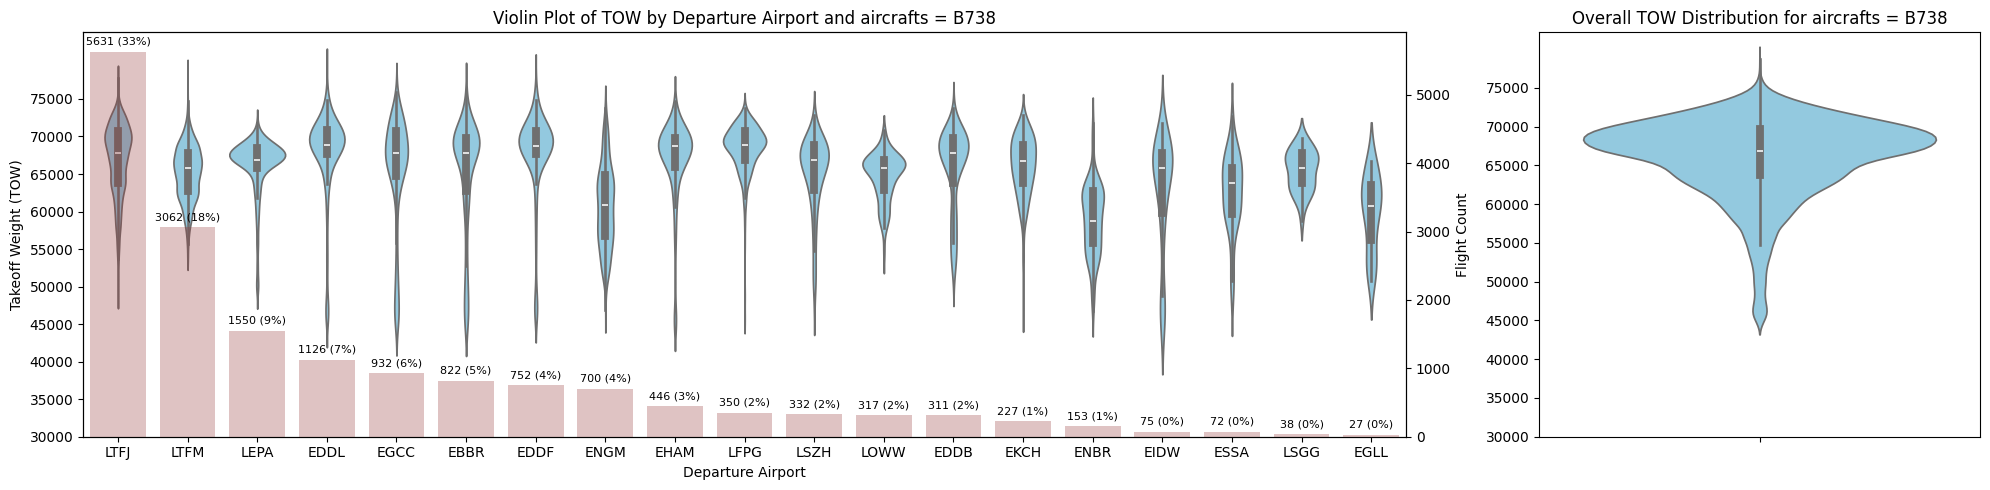

In [231]:
# Filter the dataset to keep only the rows for the top countries
df_filtered = df_train[df_train['adep'].isin(top_airports)]
p = 3

for aircraft_type in top_aircraft_types[0:p]:
    # Filter for the specific aircraft type
    df_at = df_filtered[df_filtered['aircraft_type'] == aircraft_type]

    airports_counts_at = df_at['adep'].value_counts().index

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [3, 1]})

    sns.violinplot(data=df_at, x='adep', y='tow', ax=ax1, color="skyblue", order=airports_counts_at)
    ax1.set_title('Violin Plot of TOW by Departure Airport and aircrafts = ' + aircraft_type)
    ax1.set_xlabel('Departure Airport')
    ax1.set_ylabel('Takeoff Weight (TOW)')
    ax1.set_yticks(np.arange(30000,80000,5000))
    # Create a secondary axis sharing the same x-axis for the count plot, sorted by flight counts
    ax1b = ax1.twinx()  # Secondary y-axis
    sns.countplot(data=df_at, x='adep', ax=ax1b, color="brown", alpha=0.3, order=airports_counts_at)
    ax1b.set_ylabel('Flight Count')  # Set label for the count plot
    ax1b.grid(False)  # Disable grid on the secondary axis

    for p in ax1b.patches:
        ax1b.annotate(f'{p.get_height():.0f}'+' ('+ f'{100*p.get_height()/len(df_at):.0f}'+'%)',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline',
                    fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')

    # Violin plot for the overall TOW distribution
    sns.violinplot(data=df_at, y='tow', ax=ax2, color="skyblue")
    ax2.set_title('Overall TOW Distribution for aircrafts = ' + aircraft_type)
    ax2.set_xlabel('')  # No x-axis label needed
    ax2.set_ylabel('')  # No y-axis label for the overall plot
    ax2.set_yticks(np.arange(30000,80000,5000))
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


## Focus on Airlines (29 unique)

In [232]:
# Renommage des Airlines
airlines_list = df_train['airline'].value_counts().index
renaming_airlines = {}
for i,airline in enumerate(list(airlines_list)):
  renaming_airlines[airline] = "Airline " + chr(ord('A')+i)
df_train['airline'] = df_train['airline'].replace(airline, renaming_airlines[airline])

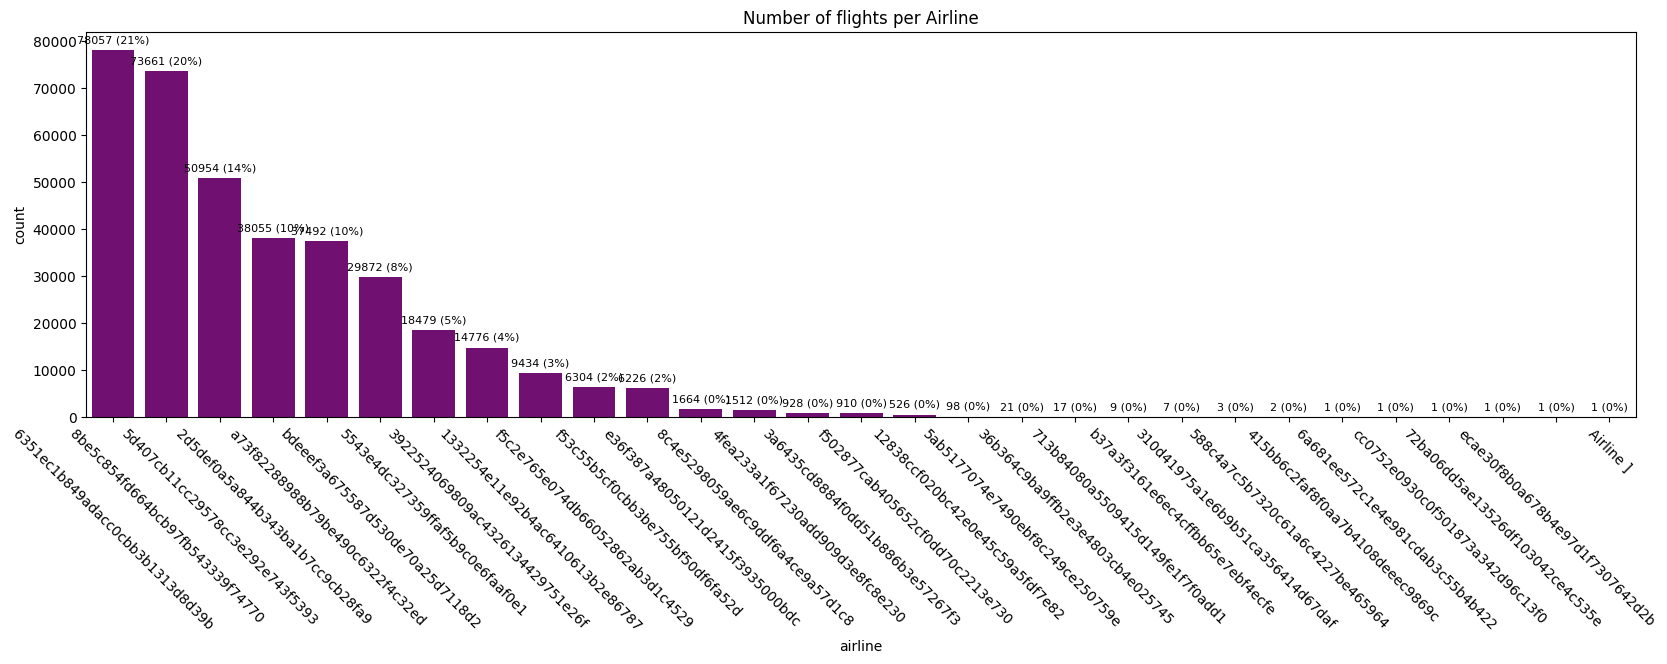

In [233]:
plt.figure(figsize = (20,5))
airline_counts = df_train.groupby('airline').size().reset_index(name='total_flights')
top_airlines = airline_counts[airline_counts['total_flights'] >= 0]['airline']
ax = sns.countplot(df_train, x = 'airline',
                   color = 'purple',
                   order = df_train['airline'].value_counts().index)
plt.xticks(rotation = -45)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}'+' ('+ f'{100*p.get_height()/len(df_train):.0f}'+'%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline',
                fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title("Number of flights per Airline")
plt.show()

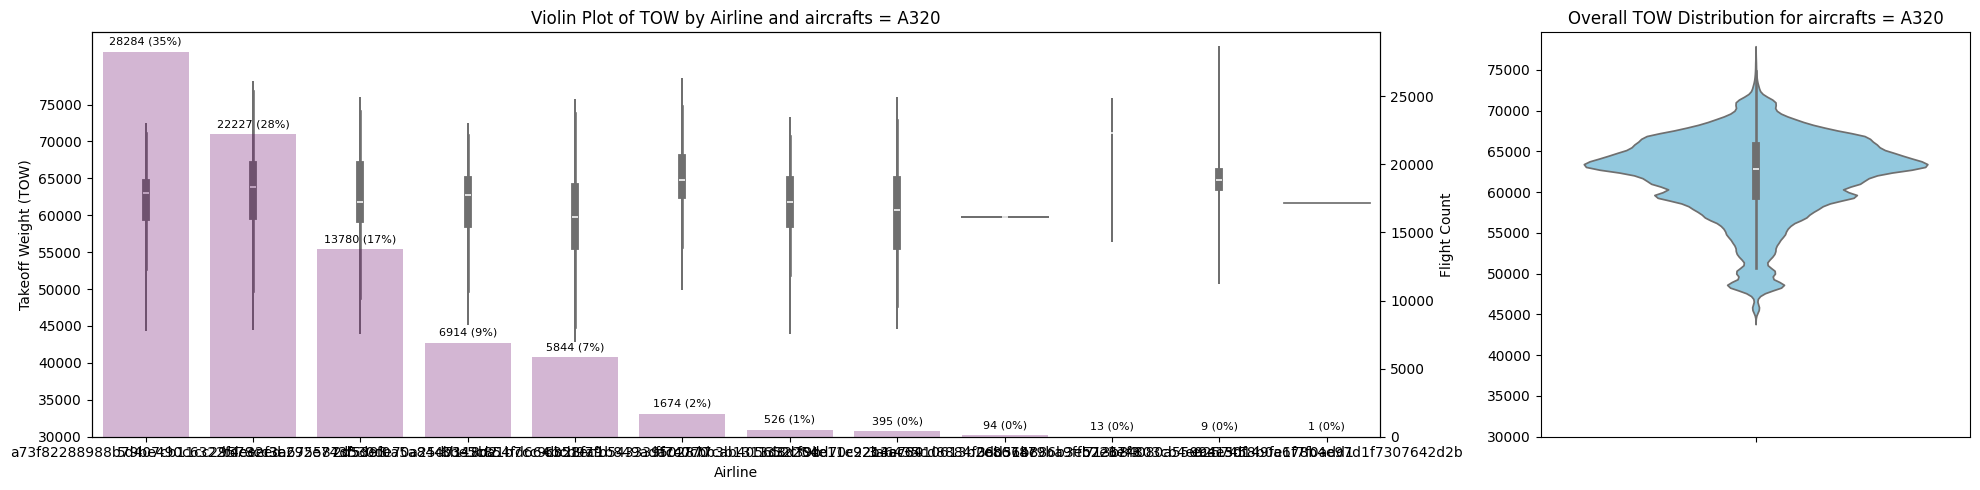

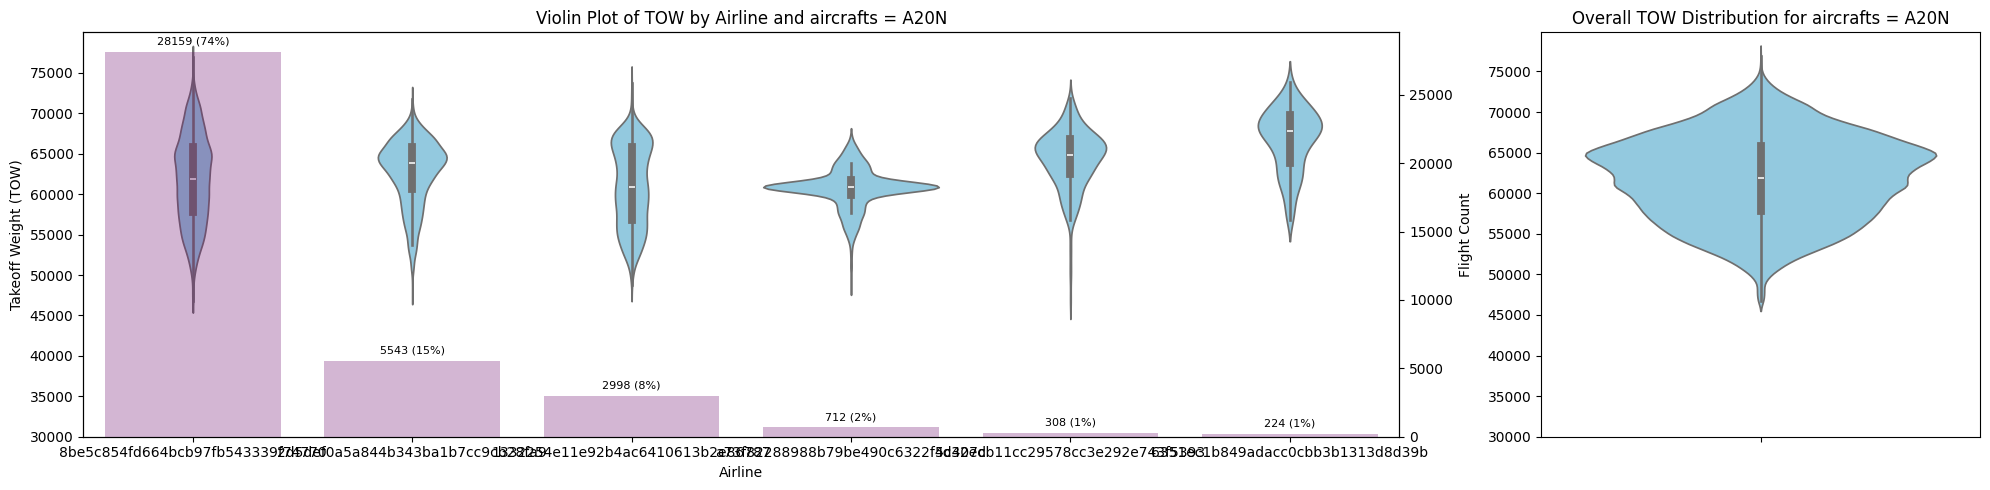

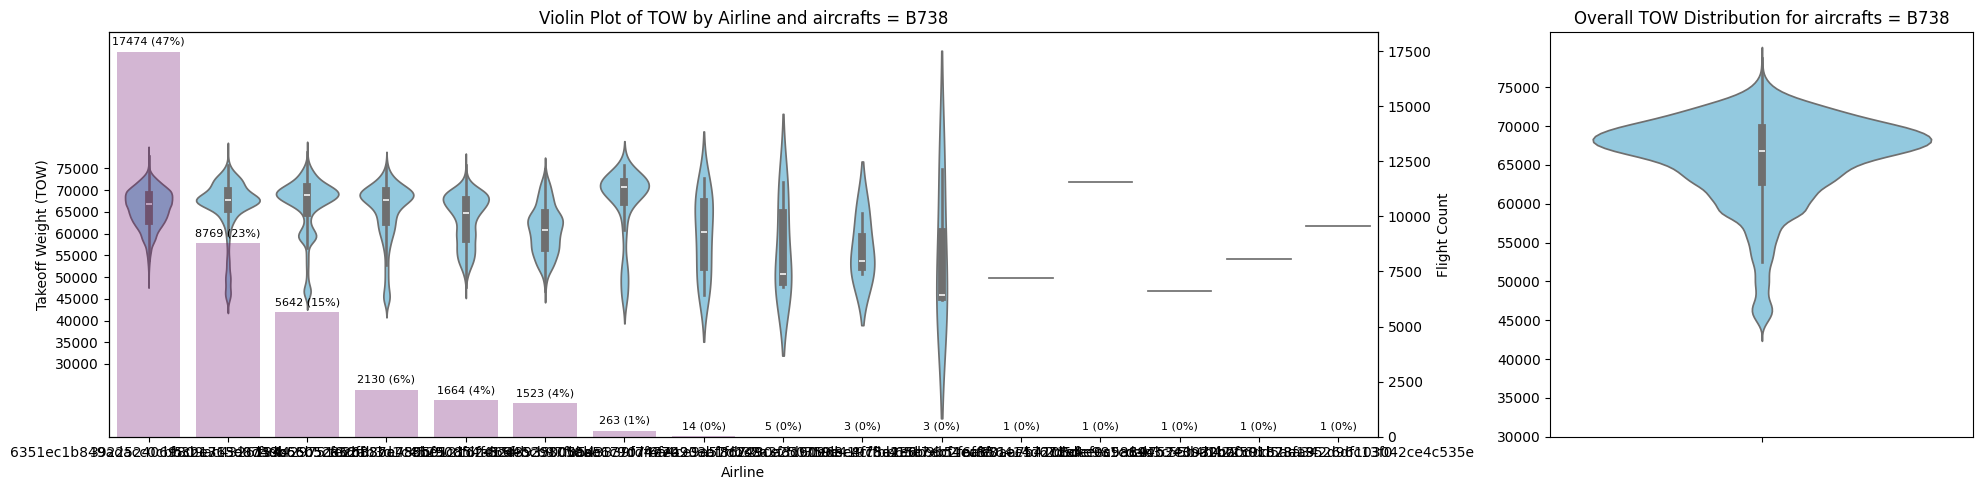

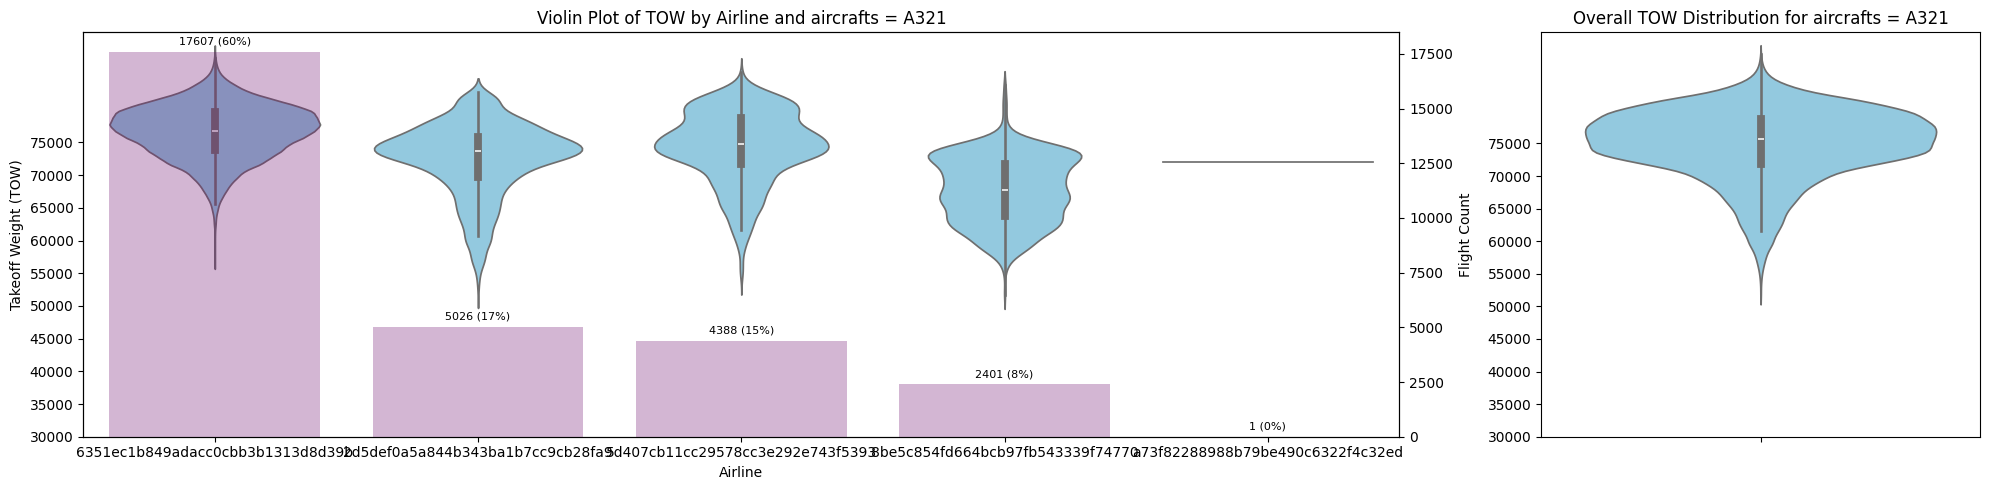

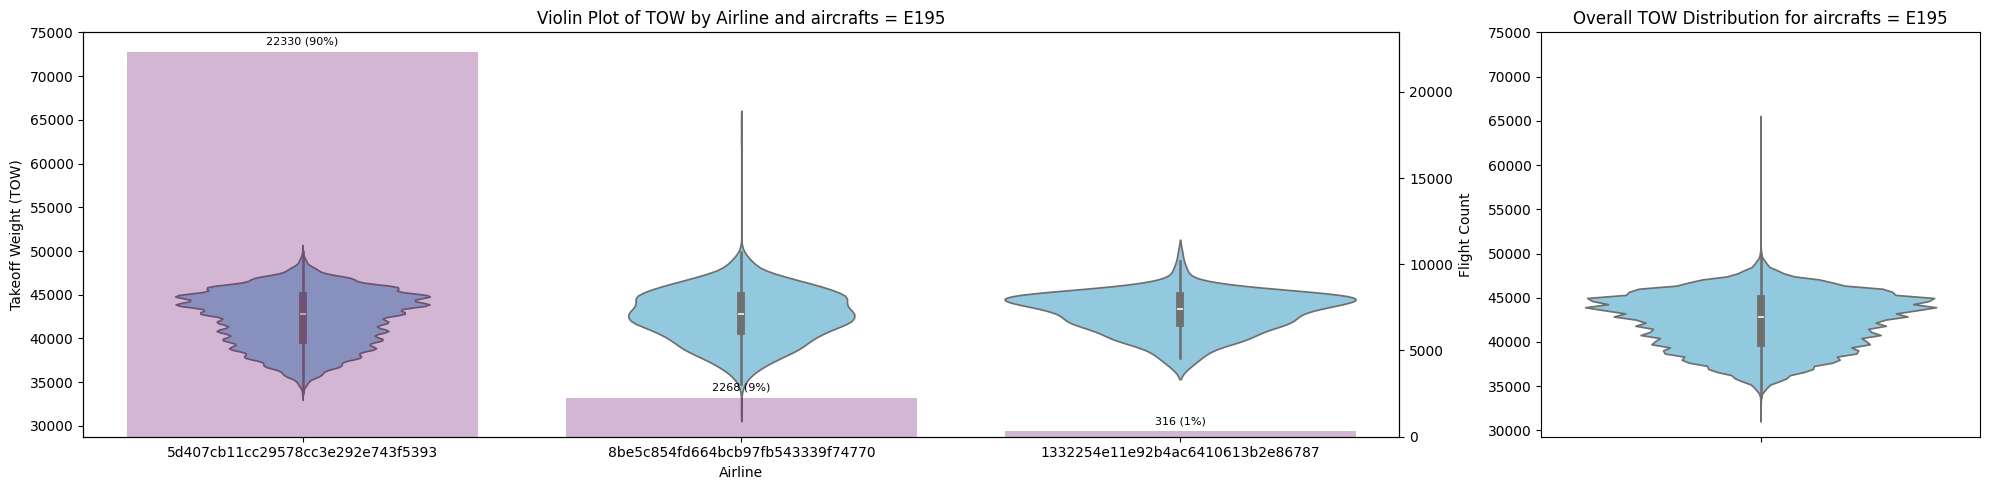

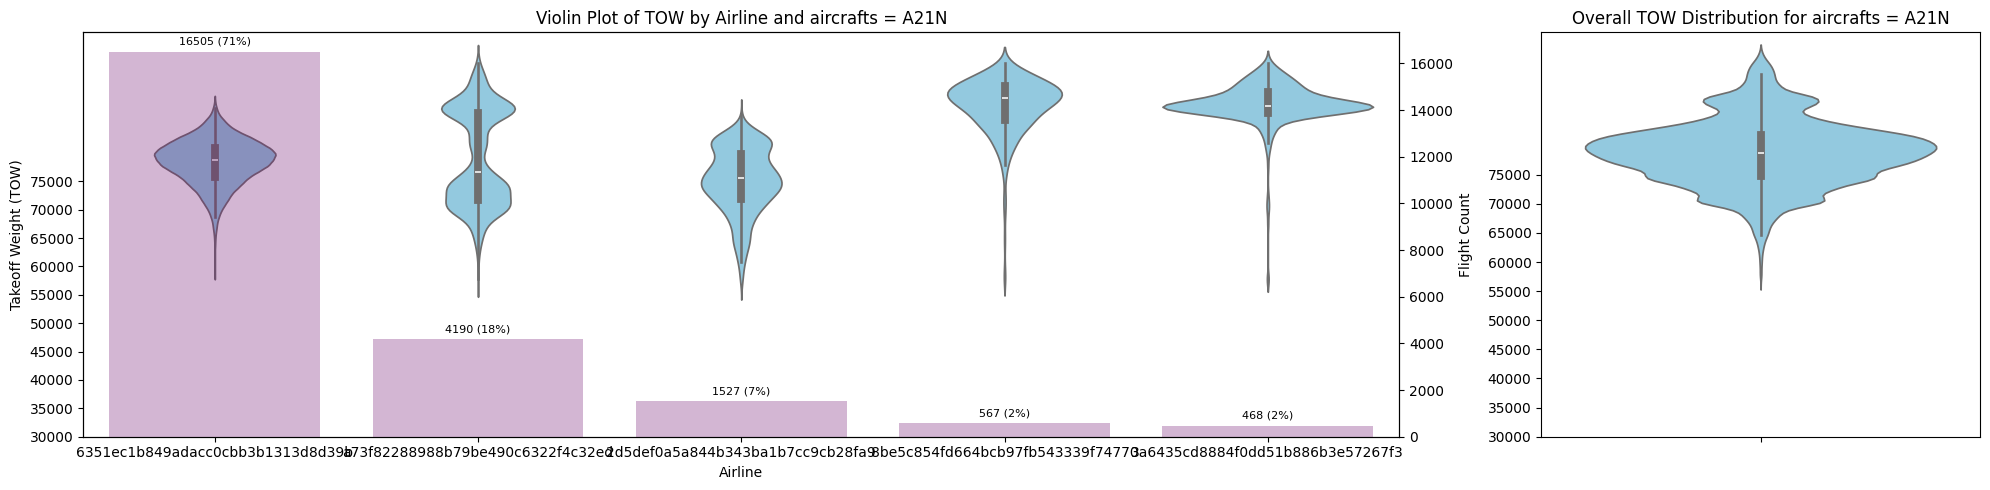

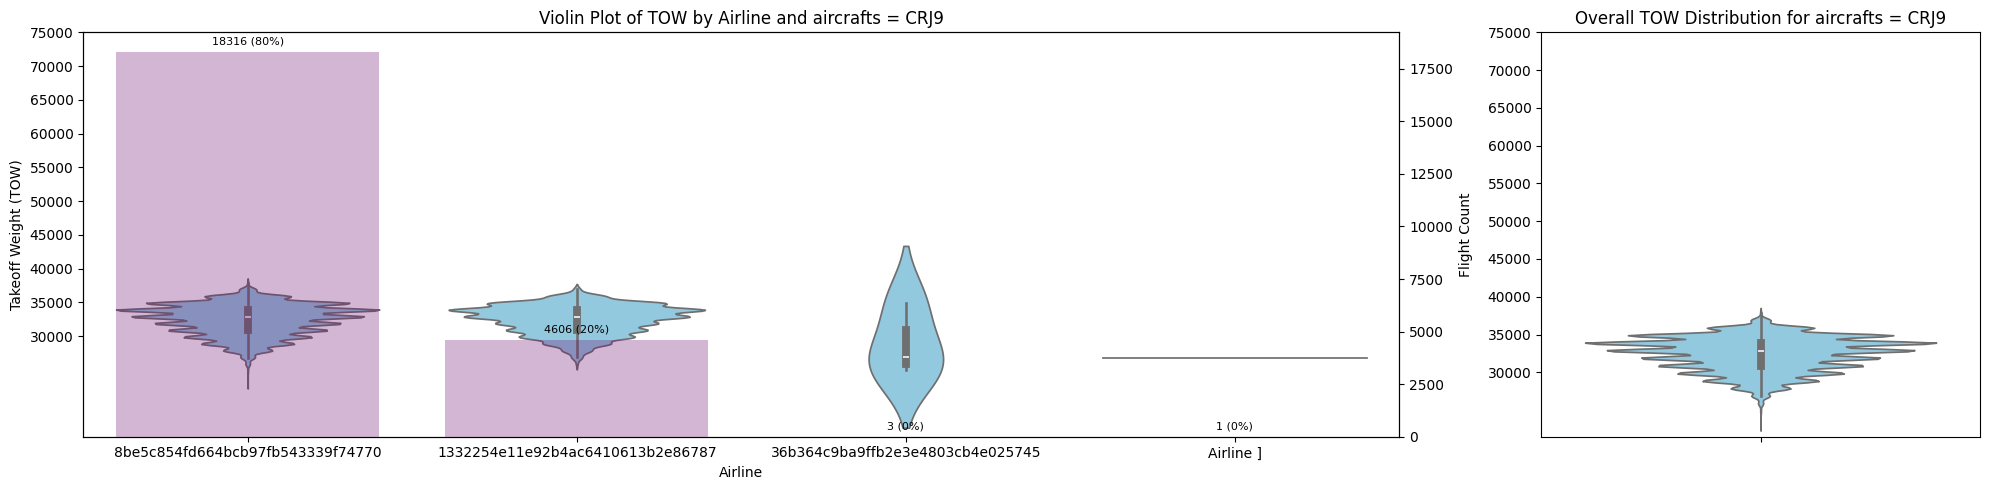

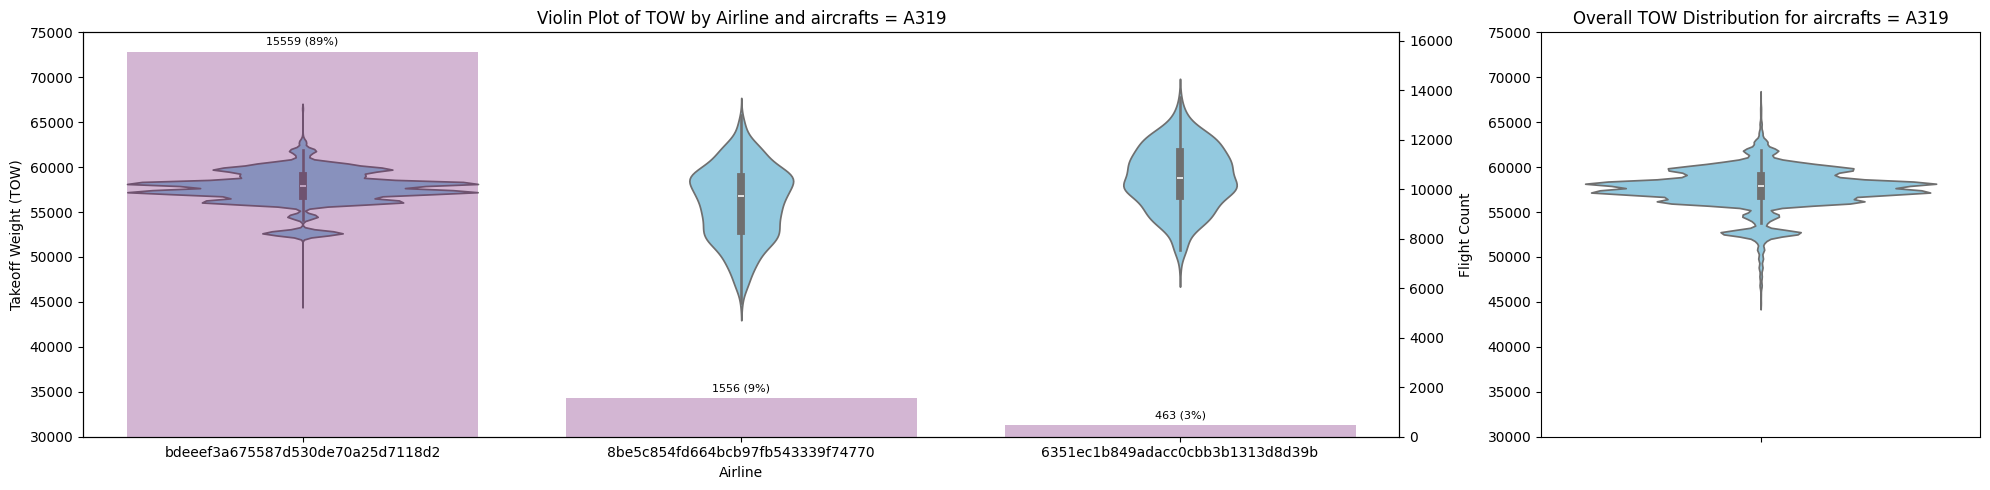

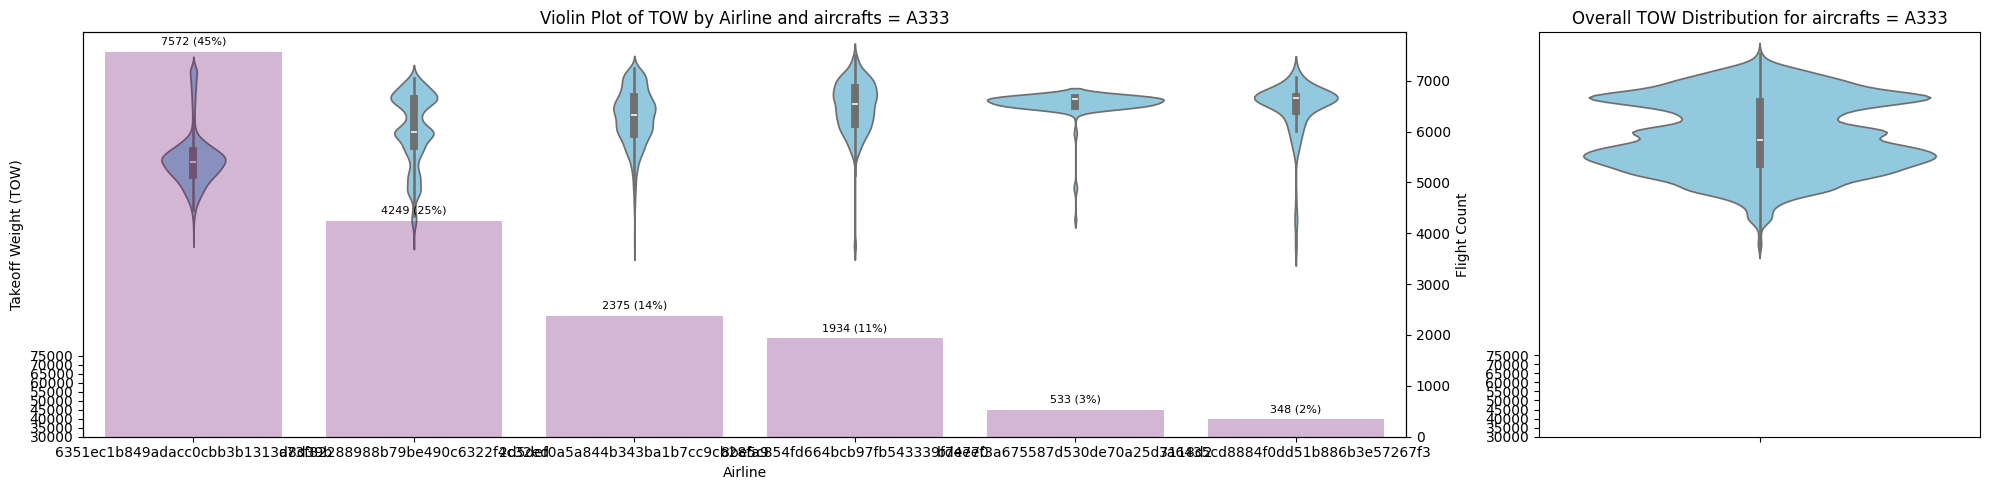

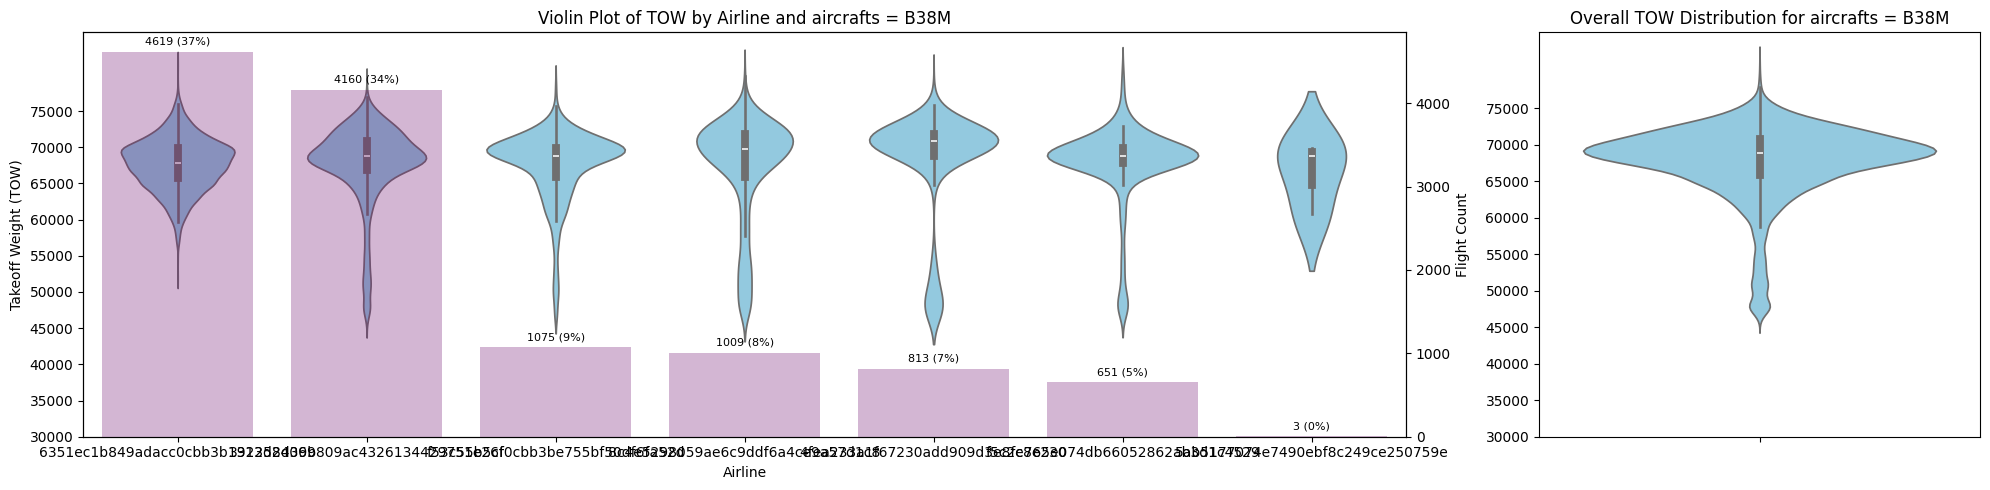

In [234]:
# Filter the dataset to keep only the rows for the top countries
df_filtered = df_train[df_train['airline'].isin(top_airlines)]
p = 10

for aircraft_type in top_aircraft_types[0:p]:
    # Filter for the specific aircraft type
    df_at = df_filtered[df_filtered['aircraft_type'] == aircraft_type]

    airports_counts_at = df_at['airline'].value_counts().index

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [3, 1]})

    sns.violinplot(data=df_at, x='airline', y='tow', ax=ax1, color="skyblue", order=airports_counts_at)
    ax1.set_title('Violin Plot of TOW by Airline and aircrafts = ' + aircraft_type)
    ax1.set_xlabel('Airline')
    ax1.set_ylabel('Takeoff Weight (TOW)')
    ax1.set_yticks(np.arange(30000,80000,5000))
    # Create a secondary axis sharing the same x-axis for the count plot, sorted by flight counts
    ax1b = ax1.twinx()  # Secondary y-axis
    sns.countplot(data=df_at, x='airline', ax=ax1b, color="purple", alpha=0.3, order=airports_counts_at)
    ax1b.set_ylabel('Flight Count')  # Set label for the count plot
    ax1b.grid(False)  # Disable grid on the secondary axis

    for p in ax1b.patches:
        ax1b.annotate(f'{p.get_height():.0f}'+' ('+ f'{100*p.get_height()/len(df_at):.0f}'+'%)',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline',
                    fontsize=8, color='black', xytext=(0, 5),
                    textcoords='offset points')

    # Violin plot for the overall TOW distribution
    sns.violinplot(data=df_at, y='tow', ax=ax2, color="skyblue")
    ax2.set_title('Overall TOW Distribution for aircrafts = ' + aircraft_type)
    ax2.set_xlabel('')  # No x-axis label needed
    ax2.set_ylabel('')  # No y-axis label for the overall plot
    ax2.set_yticks(np.arange(30000,80000,5000))
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


# Processing

## Processing: Adding longitudes, latitudes columns to df_train

In [235]:
# Computes for each airport, the corresponding lon, lat
airports_counts = df_train.groupby('adep').size().reset_index(name = 'total_flights').set_index('adep')
airports_counts['lon'], airports_counts['lat'] = np.zeros(len(airports_counts)),np.zeros(len(airports_counts))

for index, row in airports.iterrows():
    # Ensure lat/lon values are valid
    airport = row['icao']
    for (i, a) in enumerate(airports_count_dict.keys()):
      if airport == a:
        lat = row['lat']
        lon = row['lon']
        airports_counts['lat'][i] = lat
        airports_counts['lon'][i] = lon

In [236]:
# Add new columns
df_train['lon_adep'] = df_train['adep'].map(airports_counts['lon'])
df_train['lat_adep'] = df_train['adep'].map(airports_counts['lat'])
df_train['lon_ades'] = df_train['ades'].map(airports_counts['lon'])
df_train['lat_ades'] = df_train['ades'].map(airports_counts['lat'])

df_test['lon_adep'] = df_test['adep'].map(airports_counts['lon'])
df_test['lat_adep'] = df_test['adep'].map(airports_counts['lat'])
df_test['lon_ades'] = df_test['ades'].map(airports_counts['lon'])
df_test['lat_ades'] = df_test['ades'].map(airports_counts['lat'])

## Processing - Grouping and renaming of Airports

In [237]:
tiny_airports = airports_counts[airports_counts['total_flights'] < 100]
small_airports = airports_counts[airports_counts['total_flights'] < 500][airports_counts['total_flights'] > 100]
big_medium_airports = airports_counts[airports_counts['total_flights'] > 500]

In [276]:
len(tiny_airports), len(small_airports), len(big_medium_airports)

(278, 87, 94)

In [281]:
# Grouping big/medium
renaming_big_medium_airports = {name:name for name in big_medium_airports.index.unique()} # dont rename big and medium airports

# Grouping tiny airports to 30 airports
from sklearn.cluster import KMeans

k_tiny_airports = 30
names_tiny_airports = list(tiny_airports.index.unique())
renaming_tiny_airports = {name:name for name in names_tiny_airports}

X = np.array(tiny_airports[['lat', 'lon']])
kmeans = KMeans(n_clusters=k_tiny_airports, random_state=0, n_init="auto").fit(X)

for i in range(len(names_tiny_airports)):
  cluster_idx =  kmeans.labels_[i]
  renaming_tiny_airports[names_tiny_airports[i]] = f'TC{cluster_idx}'


# Grouping small airports to 30 airports
from sklearn.cluster import KMeans

k_small_airports = 30
name_small_airports = list(small_airports.index.unique())
renaming_small_airports = {name:name for name in name_small_airports}

X = np.array(small_airports[['lat', 'lon']])
kmeans = KMeans(n_clusters=k_small_airports, random_state=0, n_init="auto").fit(X)

for i in range(len(name_small_airports)):
  cluster_idx =  kmeans.labels_[i]
  renaming_small_airports[name_small_airports[i]] = f'SC{cluster_idx}'

In [282]:
len(set(renaming_tiny_airports.values())),len(set(renaming_small_airports.values())), len(set(renaming_big_medium_airports.values()))

(30, 30, 94)

In [294]:
# Perform Renaming
renaming = {}
renaming.update(renaming_big_medium_airports)
renaming.update(renaming_tiny_airports)
renaming.update(renaming_small_airports)

df_train['adep'] = df_train['adep'].replace(renaming)
df_train['ades'] = df_train['ades'].replace(renaming)
df_test['adep'] = df_test['adep'].replace(renaming)
df_test['ades'] = df_test['ades'].replace(renaming)

In [295]:
len(set(renaming.values()))

154

## Processing - Grouping and Renaming of Countries

In [240]:
countries_localisation = airports.groupby('country')[['lat','lon']].mean()

In [241]:
# Computes for each airport, the corresponding lon, lat
country_counts = df_train.groupby('country_code_adep').size().reset_index(name = 'total_flights').set_index('country_code_adep')
country_counts['lon'] = countries_localisation['lon']
country_counts['lat'] = countries_localisation['lat']
country_counts = country_counts.fillna(0)

In [265]:
tiny_countries = country_counts[country_counts['total_flights'] < 200]
small_countries = country_counts[country_counts['total_flights'] < 750][country_counts['total_flights'] > 200]
big_medium_countries = country_counts[country_counts['total_flights'] > 750]

In [286]:
len(tiny_countries), len(small_countries), len(big_medium_countries)

(63, 13, 27)

In [287]:
# Grouping big/medium
renaming_big_medium_countries = {name:name for name in big_medium_countries.index.unique()} # dont rename big and medium airports

# Grouping tiny airports to 10 countries
from sklearn.cluster import KMeans

k_tiny_countries = 10
names_tiny_countries = list(tiny_countries.index.unique())
renaming_tiny_countries = {name:name for name in names_tiny_countries}

X = np.array(tiny_countries[['lat', 'lon']])
kmeans = KMeans(n_clusters=k_tiny_countries, random_state=0, n_init="auto").fit(X)

for i in range(len(names_tiny_countries)):
  cluster_idx =  kmeans.labels_[i]
  renaming_tiny_countries[names_tiny_countries[i]] = f'TC{cluster_idx}'

# Grouping small countries to 10 countries
from sklearn.cluster import KMeans
k_small_countries = 10

name_small_countries = list(small_countries.index.unique())
renaming_small_countries = {name:name for name in name_small_countries}

X = np.array(small_countries[['lat', 'lon']])
kmeans = KMeans(n_clusters=k_small_countries, random_state=0, n_init="auto").fit(X)

for i in range(len(name_small_countries)):
  cluster_idx =  kmeans.labels_[i]
  renaming_small_countries[name_small_countries[i]] = f'SC{cluster_idx}'

In [288]:
len(set(renaming_tiny_countries.values())),len(set(renaming_small_countries.values())), len(set(renaming_big_medium_countries.values()))

(10, 10, 27)

In [292]:
# Perform Renaming
renaming_c = {}
renaming_c.update(renaming_big_medium_countries)
renaming_c.update(renaming_tiny_countries)
renaming_c.update(renaming_small_countries)

df_train['country_code_adep'] = df_train['country_code_adep'].replace(renaming_c)
df_train['country_code_ades'] = df_train['country_code_ades'].replace(renaming_c)
df_test['country_code_adep'] = df_test['country_code_adep'].replace(renaming_c)
df_test['country_code_ades'] = df_test['country_code_ades'].replace(renaming_c)

In [293]:
len(set(renaming_c.values()))

47

In [297]:
len(set(df_train['adep'].unique())),len(set(df_train['ades'].unique())),len(set(df_train['country_code_adep'].unique())),len(set(df_train['country_code_ades'].unique()))

(155, 176, 47, 52)